<a href="https://colab.research.google.com/github/meet21039/EEE-GS-513--Machine-Learning-Course-Project/blob/main/notebooks/MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, random, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, callbacks
from sklearn.metrics import classification_report, confusion_matrix

# --- Configuration ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

# Set reproducibility seeds
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [ ]:
# Load training and testing sets
train_dir = os.path.join("/content/drive/MyDrive/MRI/Training")
test_dir = os.path.join("/content/drive/MyDrive/MRITest/Testing")

# Load full training dataset first
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode="int"  # ✅ integer labels 0–3
)

# Save class names before splitting
class_names = full_train_ds.class_names
print("Detected classes:", class_names)

# Create validation split (20%)
val_size = 0.2
train_size = int((1 - val_size) * tf.data.experimental.cardinality(full_train_ds).numpy())
train_ds = full_train_ds.take(train_size)
val_ds   = full_train_ds.skip(train_size)

# Load test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode="int"
)


Found 5712 files belonging to 4 classes.
Detected classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Found 1311 files belonging to 4 classes.


In [ ]:
# Normalize and augment images
normalizer = layers.Rescaling(1./255)
augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1)
])

def preprocess(x, y, augment_flag=False):
    x = normalizer(x)
    if augment_flag:
        x = augment(x)
    return x, y

train_ds = train_ds.map(lambda x, y: preprocess(x, y, True), num_parallel_calls=AUTOTUNE)
val_ds   = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
test_ds  = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE)

# Optimize data loading
train_ds = train_ds.shuffle(1000).cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


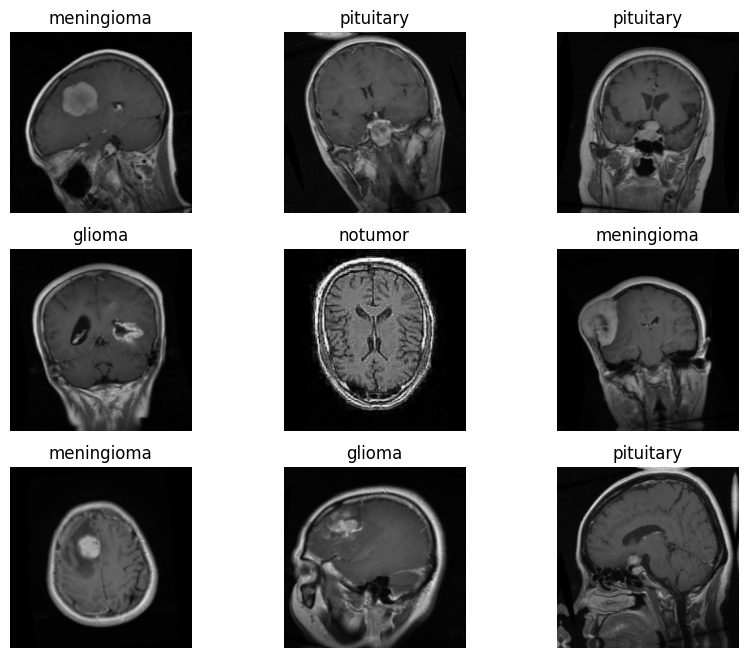

In [ ]:
# View 9 random samples from training data
plt.figure(figsize=(10,8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


In [ ]:
for x, y in train_ds.take(1):
    print("Images batch shape:", x.shape)
    print("Labels batch shape:", y.shape)
    print("Sample labels:", y[:10].numpy())


Images batch shape: (32, 224, 224, 3)
Labels batch shape: (32,)
Sample labels: [3 0 0 0 1 1 0 3 1 3]


In [ ]:
# Simple CNN for initial training
def make_baseline_cnn(input_shape=IMG_SIZE + (3,), num_classes=len(class_names)):
    model = keras.Sequential([
        layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D(2),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = make_baseline_cnn()
model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,764 (366.27 KB)

 Trainable params: 93,764 (366.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Save best model weights
checkpoint_path = "/content/drive/MyDrive/MRI/mri_baseline_best.keras"
cbs = [
    callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cbs
)


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3131 - loss: 1.3074
Epoch 1: val_accuracy improved from -inf to 0.56602, saving model to /content/drive/MyDrive/MRI/mri_baseline_best.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.3137 - loss: 1.3068 - val_accuracy: 0.5660 - val_loss: 0.9818
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5666 - loss: 1.0192
Epoch 2: val_accuracy improved from 0.56602 to 0.60387, saving model to /content/drive/MyDrive/MRI/mri_baseline_best.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.5667 - loss: 1.0191 - val_accuracy: 0.6039 - val_loss: 0.9214
Epoch 3/20
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6093 - loss: 0.9215
Epoch 3: val_accuracy did not improve from 0.60387
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6095 - loss: 0.9214 - val_accuracy: 0.4727 - val_loss: 1.1421
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6459 - loss: 0.8688
Epoc

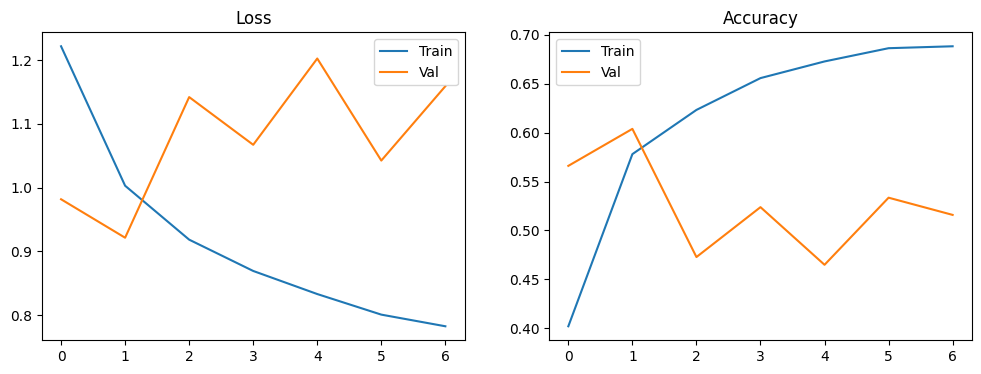

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy'); plt.legend()
plt.show()
plt.savefig("/content/drive/MyDrive/MRI/Accuracy.png")


In [ ]:
model.load_weights(checkpoint_path)

test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"\n✅ Test Accuracy: {test_acc:.3f}, Loss: {test_loss:.3f}")

# Predictions
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))




41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5203 - loss: 1.1281

✅ Test Accuracy: 0.536, Loss: 1.102
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.67      0.51      0.58       300
  meningioma       0.45      0.26      0.33       306
     notumor       0.51      0.84      0.64       405
   pituitary       0.54      0.43      0.47       300

    accuracy                           0.54      1311
   macro avg       0.54      0.51      0.51      1311
weighted avg       0.54      0.54      0.52      1311

Confusion Matrix:
[[154  72  45  29]
 [ 48  81 129  48]
 [ 19  12 340  34]
 [ 10  14 148 128]]


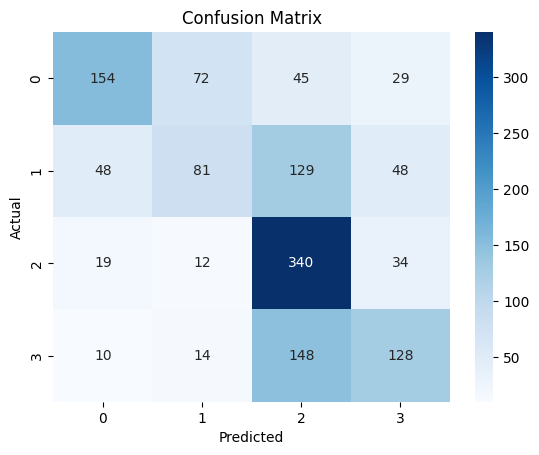

<Figure size 640x480 with 0 Axes>

In [ ]:
import seaborn as sns
cm=confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
plt.savefig("/content/drive/MyDrive/MRI/confusion_matrix.png")